In [1]:
#import needed packages.
import sys
import time
import scipy
import obspy
import pyasdf
import datetime
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
from scipy.fftpack import fft,fftfreq
from scipy.fftpack import rfft,rfftfreq,irfft

In [9]:
############################################
##functions used by the main routine
############################################

# sta_info_from_inv(inv) is modified from noise_module (with the same name)
#Check NoisePy: https://github.com/mdenolle/NoisePy
def sta_info_from_inv(inv):
    '''
    this function outputs station info from the obspy inventory object
    (used in S0B)
    PARAMETERS:
    ----------------------
    inv: obspy inventory object
    RETURNS:
    ----------------------
    sta: station name
    net: netowrk name
    lon: longitude of the station
    lat: latitude of the station
    elv: elevation of the station
    location: location code of the station
    '''
    # load from station inventory
    sta = inv[0][0].code
    net = inv[0].code
    lon = inv[0][0].longitude
    lat = inv[0][0].latitude
    if inv[0][0].elevation:
        elv = inv[0][0].elevation
    else: elv = 0.

    if inv[0][0][0].location_code:
        location = inv[0][0][0].location_code
    else: location = '00'

    return sta,net,lon,lat,elv,location

#Stolen from NoisePy
def segment_interpolate(sig1,nfric):
    '''
    this function interpolates the data to ensure all points located on interger times of the
    sampling rate (e.g., starttime = 00:00:00.015, delta = 0.05.)
    PARAMETERS:
    ----------------------
    sig1:  seismic recordings in a 1D array
    nfric: the amount of time difference between the point and the adjacent assumed samples
    RETURNS:
    ----------------------
    sig2:  interpolated seismic recordings on the sampling points
    '''
    npts = len(sig1)
    sig2 = np.zeros(npts,dtype=np.float32)

    #----instead of shifting, do a interpolation------
    for ii in range(npts):

        #----deal with edges-----
        if ii==0 or ii==npts-1:
            sig2[ii]=sig1[ii]
        else:
            #------interpolate using a hat function------
            sig2[ii]=(1-nfric)*sig1[ii+1]+nfric*sig1[ii]

    return sig2

# Modified from Zhitu Ma. Modified by Xiaotao Yang
# 1. Reduce input arguments to only read in windown length. Windows will be calculated. 
# 2. Future: Need to revert back to getting windows by excluding earthquakes
def gettransfer(y1,y2,winlen=2000,iplot=False):
    """ calculate the transfer function from y1 to y2
    return the coherence, admittance, phase and their corresponding error
    """
    
    iopt=1
    nsamp=len(y1)
    wins=np.arange(0,nsamp-winlen,winlen)
    
    coh_debug=[]
    win_debug=[]
    
    for ijk,win in enumerate(wins):
        y1tmp=y1[win:win+winlen]
        y2tmp=y2[win:win+winlen]
        hann=np.hanning(winlen)
        y1_fft=np.split(fft(hann*y1tmp),2)[0]
        y2_fft=np.split(fft(hann*y2tmp),2)[0]
        if (ijk == 0):
            Gxy=np.conj(y1_fft)*y2_fft
            Gxx=np.conj(y1_fft)*y1_fft
            Gyy=np.conj(y2_fft)*y2_fft
        else:
            Gxy=Gxy+np.conj(y1_fft)*y2_fft
            Gxx=Gxx+np.conj(y1_fft)*y1_fft
            Gyy=Gyy+np.conj(y2_fft)*y2_fft
    
        ff=np.split(fftfreq(winlen,1.0),2)[0]   
#         idx=(ff>0.005) & (ff<0.010)
        cohtmp=np.abs(Gxy)**2/np.real(Gxx)/np.real(Gyy)
        cohtmp=np.sqrt(cohtmp)
        coh_debug.append(np.mean(cohtmp))
        win_debug.append(win)

            
    coh=np.abs(Gxy)**2/np.real(Gxx)/np.real(Gyy)
    coh=np.sqrt(coh)
    if (iopt == 0):
        adm=0.
        phs=0.
        adm_err=0.
        phs_err=0.
    else:
        adm=np.abs(Gxy)/np.real(Gxx)
        phs=np.angle(Gxy)
        nd=len(wins)
        adm_err=np.sqrt(1.-coh**2)/coh/np.sqrt(2*nd)
        adm_err=adm*adm_err
        phs_err=adm_err
    ff=np.split(fftfreq(winlen,1.0),2)[0]
    
    if iplot:
        plt.figure(figsize=(12,5))
        plt.plot(win_debug,coh_debug,'o')
        plt.xlabel("window")
        plt.ylabel("coherence")
        plt.title("Debug transfer function")

    return ff,coh,adm,phs,adm_err,phs_err

# From Zhitu Ma. Modified by Xiaotao Yang
# 1. Use freqmin and freqmax, instead of f1 and f2
# 2. Changed to include the two ending frequencies.
#
def docorrection(tr1,tr2,adm,adm_err,phs,phs_err,freqmin,freqmax,ff,iplot=0):
    """ calculate a quadratic fit to adm and phs
    use this information to predict from tr1, then remove this from tr2
    returning two trace (obspy class), one is the prediction
    one is this prediction removed from tr2 """
    idx=(ff>=freqmin) & (ff<=freqmax)
    ff_select=ff[idx]
    adm_select=adm[idx]
    adm_err_select=adm_err[idx]
    w=1./adm_err_select
    apol=np.polyfit(ff_select,adm_select,2,w=w)
    phs_select=phs[idx]
    phs_err_select=phs_err[idx]
    w=1./phs_err_select
    ppol=np.polyfit(ff_select,phs_select,2,w=w)
    
    if (iplot==1):
        plt.subplot(1,2,1)
        adm_fit=apol[0]*ff_select**2+apol[1]*ff_select+apol[2]
        plt.plot(ff_select,adm_select)
        plt.plot(ff_select,adm_fit)
        plt.xlabel("frequency (Hz)")
        plt.ylabel("admittance")
        plt.subplot(1,2,2)
        phs_fit=ppol[0]*ff_select**2+ppol[1]*ff_select+ppol[2]
        plt.plot(ff_select,phs_select)
        plt.plot(ff_select,phs_fit)
        plt.xlabel("frequency (Hz)")
        plt.ylabel("phase shift")
        plt.show()
        plt.close()
    
    ffr=rfftfreq(len(tr1.data),1.0)
    tr_pred=tr1.copy()
    tr_left=tr1.copy()
    Htmp_spec=rfft(tr1.data)
    Htmp_spec[0]=0
    Htmp_spec[-1]=0
    for i in np.arange(1,len(ffr)-1,2):
        rp=Htmp_spec[i]
        ip=Htmp_spec[i+1]
        if(ffr[i]>freqmax or ffr[i]<freqmin):
            Htmp_spec[i]=0.
            Htmp_spec[i+1]=0.
            continue
        amp=apol[0]*ffr[i]**2+apol[1]*ffr[i]+apol[2]
        phs=ppol[0]*ffr[i]**2+ppol[1]*ffr[i]+ppol[2]
        c=amp*np.cos(phs)
        d=amp*np.sin(phs)
        Htmp_spec[i]=rp*c-ip*d
        Htmp_spec[i+1]=ip*c+rp*d
    Htmp=irfft(Htmp_spec)
    tr_pred.data=Htmp
    tr_left.data=tr2.data-Htmp
    return tr_pred,tr_left


# Modified from Zhitu Ma. Modified by Xiaotao to get filter frequencies from the arguments
# 1. added titles for multiple plots
# 2. determine freqmax as the Nyquist frequency, if not specified
def plot_trace(tr_list,freqmin=0.02,freqmax=[],size=(10,9),labels=[],title=[],outfile='test.ps',xlimit=[]):
    plt.figure(figsize=size)
    ntr=len(tr_list)
#     fac=[1e+6,1e+3,1e+3,1e+3,1e+6,1e+6,1,1e+6,1e+6]
    
    for itr,tr in enumerate(tr_list,1):
        tt=tr.times()
        imin = next(i for i, _ in enumerate(tt) if np.isclose(_, xlimit[0], tt[1]-tt[0]))
        imax = next(i for i, _ in enumerate(tt) if np.isclose(_, xlimit[1], tt[1]-tt[0]))
        
        tc=tr.copy()
        if freqmax==[]:
            freqmax=0.4999*tr.stats.sampling_rate #slightly lower than the Nyquist frequency
        
        print("station %s.%s, filtered at [%5.2f, %5.2f]" % (tr.stats.network,tr.stats.station,freqmin,freqmax))
        tc.filter('bandpass',freqmin=freqmin,freqmax=freqmax)
        ax=plt.subplot(ntr,1,itr)
        plt.plot(tt,tc.data);
        plt.xlabel("time (s)")
        ax.ticklabel_format(style='plain')
        if itr < len(tr_list):
            ax.tick_params(labelbottom=False)
        if (len(labels)>0):
            plt.ylabel(labels[itr-1])
        if len(title)>0:
            plt.title(title[itr-1])
        if len(xlimit)>0:
            plt.xlim(xlimit)
        plt.ylim(0.9*np.min(tc.data[imin[0]:imax[0]]),1.1*np.max(tc.data[imin[0]:imax[0]]))
            
    plt.savefig(outfile,orientation='landscape')

In [3]:
#set global parameters
datadir="/Users/xiaotaoyang/Work/testprograms/Raw/2012"
datafile=os.path.join(datadir,"2012_01_31_00_00_00T2012_02_01_00_00_00.h5")
input_fmt='asdf'
pressurechan='HDH'
vflag=True #verbose flag;

found 214 stations in total
 station 3 of 214
('FN07A', '7D', -124.786499, 46.855499, -154.0, '00')
pressure channel HDH
vertical channel HHZ


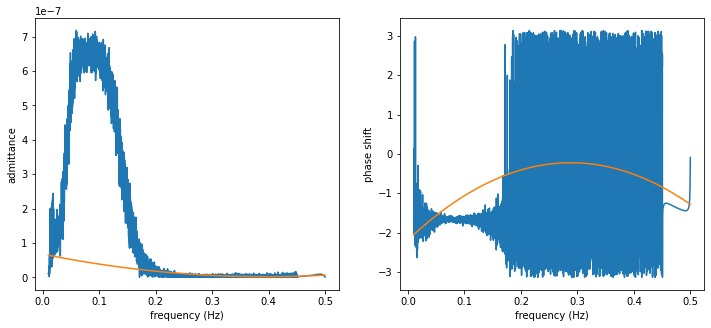

station 7D.FN07A, filtered at [ 0.01,  1.00]
station 7D.FN07A, filtered at [ 0.01,  1.00]
station 7D.FN07A, filtered at [ 0.01,  1.00]
station 7D.FN07A, filtered at [ 0.01,  1.00]


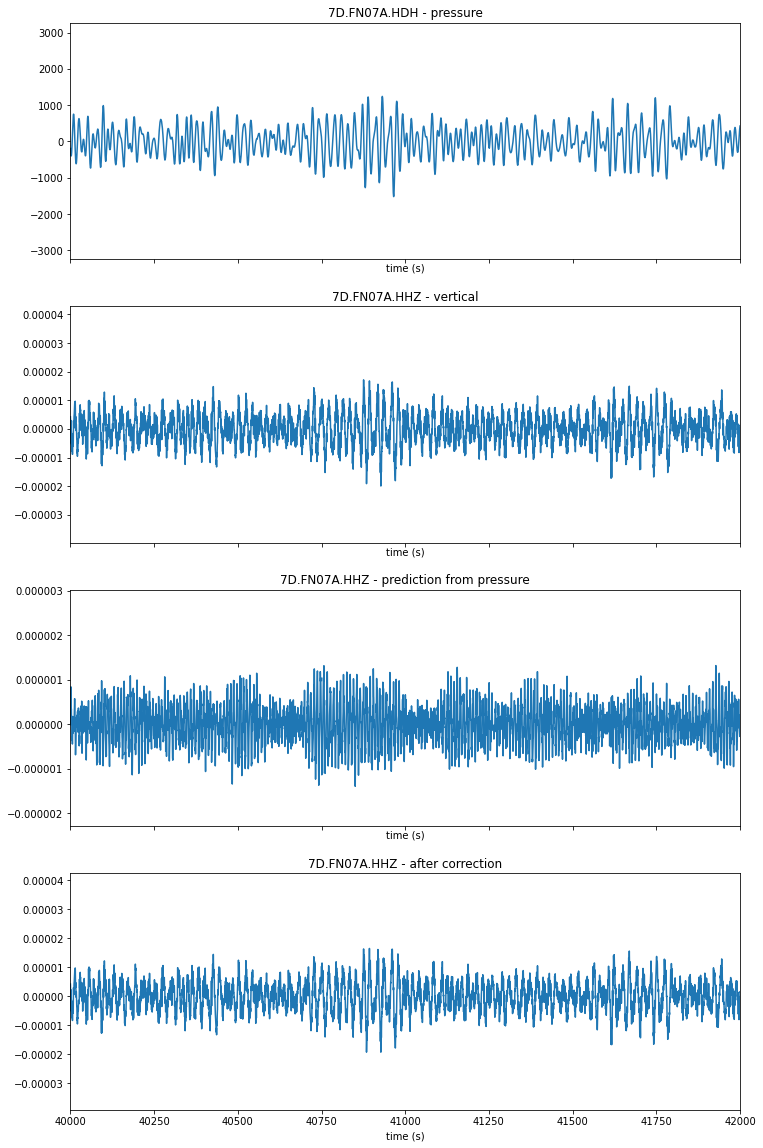

In [174]:
################################################
## Main codes to do the correction for multiple data files.
################################################
"""
   Read in data from asdf file.
   NOTE: this will be put into a loop for all data files 
"""
dfile=datafile
ds=pyasdf.ASDFDataSet(dfile,mpi=False,mode='r')
sta_list = ds.waveforms.list()
nsta=len(sta_list)
print('found %d stations in total'%nsta)

###NOTE: for debugging, i use range(1). should change to range(nsta) for all stations on the list
for ista in [3]:#range(20): 
    tmps = sta_list[ista]
    print(" station %d of %d" % (ista,nsta))
    try:
        inv1 = ds.waveforms[tmps]['StationXML']
    except Exception as e:
        print('abort! no stationxml for %s in file %s'%(tmps,tdir[ick]))
        continue
    sta,net,lon,lat,elv,loc = sta_info_from_inv(inv1)
    print((sta,net,lon,lat,elv,loc))

    if elv < -10e-5: #only check OBS with negative elevation
        trall=[]
        trlabels=[]
        # get days information: works better than just list the tags
        all_tags = ds.waveforms[tmps].get_waveform_tags()
        if len(all_tags)==0:continue
#         print(all_tags)
        if pressurechan.lower()+'_00' not in all_tags:
            continue
        # read waveform data
        # FUTURE: get tags for pressure and vertical channels through automatic detection.
        try:
            trP = ds.waveforms[tmps]['hdh_00'] 
        except Exception as e:
            print(e)
            continue
        
        trall.append(trP[0])
        compP = trP[0].stats.channel
        trlabels.append(net+"."+sta+"."+compP+" - pressure")
        
        if vflag:print("pressure channel %s" % (compP))
        
        try:
            trZ = ds.waveforms[tmps]['hhz_00']
        except Exception as e:
            print(e)
            try:
                trZ = ds.waveforms[tmps]['bhz_00']
            except Exception as e:
                print(e)
                continue
        trall.append(trZ[0])
        compZ = trZ[0].stats.channel
        trlabels.append(net+"."+sta+"."+compZ+" - vertical")
        
        if vflag:print("vertical channel %s" % (compZ))        
        
        #get the transfer function
        freqmin=0.01
        freqmax=1
        ff,coh,adm,phs,adm_err,phs_err = gettransfer(trall[0].data,trall[1].data,iplot=True,winlen=20000)
        # do correction now.
        trZ_pred,trZ_left = docorrection(trall[0],trall[1],adm,adm_err,phs,phs_err,freqmin,freqmax,ff,iplot=1)
        
        trall.append(trZ_pred)
        trlabels.append(net+"."+sta+"."+compZ+" - prediction from pressure")
        trall.append(trZ_left)
        trlabels.append(net+"."+sta+"."+compZ+" - after correction")
#         print(ff,coh,adm,phs,adm_err,phs_err)
    #     #----loop through each stream----
    #     for itag in range(len(all_tags)):
    #         #may put pressure channel as a variable in the future

    #         # read waveform data
    #         tr = ds.waveforms[tmps][all_tags[itag]]
    #         if len(tr)==0:continue

    #         # channel info
    #         comp = tr[0].stats.channel

        #plot all traces
        plot_trace(trall,size=(12,20),title=trlabels,freqmin=freqmin,freqmax=freqmax,xlimit=(40000,42000))
        

